In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import pickle
import seaborn as sns

from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans, DBSCAN
from nltk.util import ngrams
from nltk.text import TextCollection
from sklearn.decomposition import NMF
from gensim import corpora, models, similarities, matutils
from collections import Counter

In [173]:
data = pd.read_csv('profiles.csv')

In [174]:
data.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [175]:
data.iloc[0][['essay' + str(i) for i in range(10)]]

essay0    about me:<br />\n<br />\ni would love to think...
essay1    currently working as an international agent fo...
essay2    making people laugh.<br />\nranting about a go...
essay3    the way i look. i am a six foot half asian, ha...
essay4    books:<br />\nabsurdistan, the republic, of mi...
essay5    food.<br />\nwater.<br />\ncell phone.<br />\n...
essay6                          duality and humorous things
essay7    trying to find someone to hang out with. i am ...
essay8    i am new to california and looking for someone...
essay9    you want to be swept off your feet!<br />\nyou...
Name: 0, dtype: object

In [176]:
data.dtypes

age              int64
body_type       object
diet            object
drinks          object
drugs           object
education       object
essay0          object
essay1          object
essay2          object
essay3          object
essay4          object
essay5          object
essay6          object
essay7          object
essay8          object
essay9          object
ethnicity       object
height         float64
income           int64
job             object
last_online     object
location        object
offspring       object
orientation     object
pets            object
religion        object
sex             object
sign            object
smokes          object
speaks          object
status          object
dtype: object

In [177]:
data.isnull().sum()

age                0
body_type       5296
diet           24395
drinks          2985
drugs          14080
education       6628
essay0          5488
essay1          7572
essay2          9638
essay3         11476
essay4         10537
essay5         10850
essay6         13771
essay7         12451
essay8         19225
essay9         12603
ethnicity       5680
height             3
income             0
job             8198
last_online        0
location           0
offspring      35561
orientation        0
pets           19921
religion       20226
sex                0
sign           11056
smokes          5512
speaks            50
status             0
dtype: int64

In [178]:
sex_male = pd.get_dummies(data.sex, drop_first=True).iloc[:, 0]

In [179]:
X = data[['essay' + str(i) for i in range(10)]]

In [180]:
X = X.fillna('')

In [181]:
X = X.apply(lambda row: ' '.join(row), axis=1).to_frame()

In [182]:
n=10
for profile in X.sample(n, random_state=42)[0]:
    print(profile)
    print('*'*50)

i am really obsessed with music and would love to do something with
it. my music idol is tom delonge. my friends always make fun of me
because i buy anything he does. i am supervisor and i am really bored of it. i really need to get
back into school. guitar i like to think i am alright. i am always trying to improve
at it. well used to be my hair. had to get rid of the blonde mohawk. so
now i would say my plugs. i usually get somekind of comment to my
earrings. to many movies to just pick one and same with tv shows. but some of
the best are scott pilgrim and the office.<br />
music is the best thing ever and i surround myself with it
everyday.<br />
pizza is the best food i could eat it when ever. my brother<br />
my guitars<br />
my friends<br />
my phone<br />
my ps3<br />
and oxygen obviously  trying to have fun in what ever is fun to do that night.  want to be friends. to see whats up? or what ever reason you can
think of. lets talk
*************************************************

In [183]:
X.sample(10, random_state=42).shape

(10, 1)

In [184]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'lxml')
    stripped_text = soup.get_text()
    return stripped_text

In [185]:
def custom_tokenizer(text):
    text = strip_html_tags(text)
    
    remove_punct = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(remove_punct)
    
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)
    
    tokens = word_tokenize(text)
    
    stop_words = stopwords.words('english')
    tokens_stop = [y for y in tokens if y not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(y) for y in tokens_stop]
    
    stemmer = SnowballStemmer('english')
    tokens_stem = [stemmer.stem(y) for y in tokens_lemma]
    
    custom_stop_words = ['like','love','good','thing','go','life',
                         'realli','also','think','one','want',
                        'probabl','im', 'would', 'dont', 'enjoy',
                         'lot', 'someth', 'favorit', 'make',
                         'even', 'usual', 'anything','could',
                        'know', 'get', 'anyth', 'sometim', 'come', 'actual', 'much',
                        'never', 'though', 'say', 'way', 'use', 'day', 'well',
                        'right', 'time', 'other', 'still', 'littl', 'need',
                        'bit', 'without', 'feel', 'find', 'got', 'seem']
    tokens_final = [y for y in tokens_stem if y not in custom_stop_words]
    
    return tokens_final

In [169]:
WordNetLemmatizer().lemmatize('get')

'get'

In [171]:
# textcollection = TextCollection(list(map(custom_tokenizer, X[0])))

In [172]:
# sorted([(i, 1/np.exp(textcollection.idf(i))) for i in textcollection.vocab()], key=lambda x: x[1], reverse=True)

In [186]:
# cv = CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1,2), min_df=30, max_df=.8)
# X_cv = cv.fit_transform(X[0])

In [187]:
# tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, ngram_range=(1,2), min_df=30, max_df=.8)
# X_tfidf = tfidf.fit_transform(X[0])

In [188]:
# with open('matrix_tfidf.pkl', 'wb') as handle:
#     pickle.dump(X_tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('tfidfvec.pkl', 'wb') as f:
#     pickle.dump(tfidf, f, protocol=pickle.HIGHEST_PROTOCOL)

# with open('words_sparse_matrix.pkl', 'wb') as handle:
#     pickle.dump(X_cv, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('countvec.pkl', 'wb') as f:
#     pickle.dump(cv, f, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
tfidf.get_feature_names()

['aa',
 'aaliyah',
 'aaron',
 'aau',
 'ab',
 'abalon',
 'abandon',
 'abba',
 'abbey',
 'abbi',
 'abbrevi',
 'abc',
 'abe',
 'abhor',
 'abid',
 'abil',
 'abl',
 'abnorm',
 'aboard',
 'abomin',
 'abort',
 'abound',
 'abraham',
 'abram',
 'abras',
 'abridg',
 'abroad',
 'abrupt',
 'absenc',
 'absent',
 'absinth',
 'absolut',
 'absorb',
 'abstract',
 'absurd',
 'absurdist',
 'abund',
 'abus',
 'abyss',
 'ac',
 'academ',
 'academi',
 'academia',
 'acceler',
 'accent',
 'accept',
 'access',
 'accessor',
 'accessori',
 'accid',
 'accident',
 'acclaim',
 'acclim',
 'accommod',
 'accompani',
 'accomplic',
 'accomplish',
 'accord',
 'accordion',
 'account',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'accustom',
 'acdc',
 'ace',
 'acerb',
 'ach',
 'achewood',
 'achiev',
 'acid',
 'acknowledg',
 'acm',
 'acoust',
 'acquaint',
 'acquir',
 'acquisit',
 'acr',
 'acrobat',
 'acronym',
 'across',
 'acryl',
 'act',
 'action',
 'activ',
 'activist',
 'activit',
 'actor',
 'actress',
 'actual',
 'acupu

In [189]:
X_tfidf

<59946x45269 sparse matrix of type '<class 'numpy.float64'>'
	with 11038247 stored elements in Compressed Sparse Row format>

In [190]:
def show_variance_explained_plots(pca):
    
    var_exp_array = pca.explained_variance_ratio_
    n_comps = var_exp_array.shape[0] 
    
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    ax[0].fill_between(range(n_comps), var_exp_array)
    ax[0].set_title('Variance Explained by Nth Principal Component')
    
    ax[1].fill_between(range(n_comps), np.cumsum(var_exp_array))
    ax[1].set_title('Cumulative Variance Explained by N Components')
    
    plt.show()

In [191]:
def print_topics(model, vectorizer, n_topics=10, top_n=10):
    for idx, topic in list(enumerate(model.components_))[:n_topics]:
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], '{:.4f}'.format(topic[i]))
                        for i,_ in sorted(enumerate(topic), key=lambda x: abs(x[1]))[-top_n:][::-1]])

##  LSA
### countvec

In [52]:
with open('words_sparse_matrix.pkl', 'rb') as handle:
    X_cv = pickle.load(handle)

with open('countvec.pkl', 'rb') as handle:
    cv = pickle.load(handle)

In [53]:
pca_cv = TruncatedSVD(n_components=20)
X_cv = pca_cv.fit_transform(X_cv)

In [54]:
pca_cv.explained_variance_ratio_.sum()

0.1856902881642387

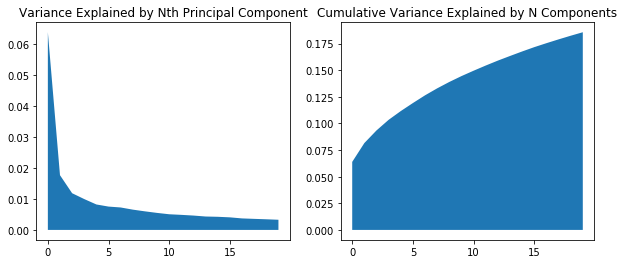

In [72]:
show_variance_explained_plots(pca_cv)

In [73]:
print_topics(pca_cv, cv)

Topic 0:
[('friend', '0.2551'), ('time', '0.2328'), ('peopl', '0.2317'), ('music', '0.2260'), ('work', '0.2099'), ('movi', '0.1761'), ('food', '0.1716'), ('new', '0.1562'), ('book', '0.1477'), ('tri', '0.1283')]
Topic 1:
[('word', '0.7788'), ('word word', '0.6003'), ('five', '0.0983'), ('hundr', '0.0972'), ('friend', '-0.0468'), ('thou', '0.0297'), ('new', '-0.0257'), ('music', '-0.0244'), ('profil', '0.0233'), ('food', '-0.0231')]
Topic 2:
[('friend', '-0.3671'), ('peopl', '0.2924'), ('music', '-0.2683'), ('food', '-0.2170'), ('movi', '-0.2151'), ('famili', '-0.1822'), ('new', '-0.1531'), ('way', '0.1281'), ('feel', '0.1203'), ('time', '0.1184')]
Topic 3:
[('music', '0.4994'), ('friend', '-0.4019'), ('movi', '0.2082'), ('book', '0.1930'), ('new', '-0.1704'), ('famili', '-0.1459'), ('peopl', '-0.1420'), ('food', '0.1375'), ('work', '-0.1296'), ('someon', '-0.1288')]
Topic 4:
[('http', '0.2729'), ('friend', '0.2709'), ('watch', '0.2664'), ('com', '0.2644'), ('www', '0.2549'), ('http www

In [21]:
k_means_cluster = KMeans(n_clusters=5)

cluster_labels = k_means_cluster.fit_predict(X_cv[:, :200])

Percentage of 1s in cluster 0: 0.5788813339808969
Percentage of 1s in cluster 1: 0.6354957388348158
Percentage of 1s in cluster 2: 0.5931919642857143
Percentage of 1s in cluster 3: 1.0
Percentage of 1s in cluster 4: 0.5693284330103575


/home/ubuntu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


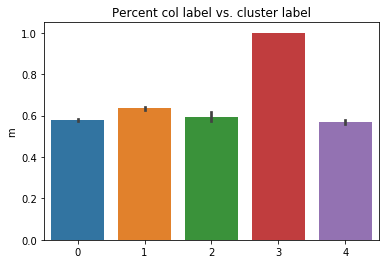

In [22]:
def show_cluster_stats(cluster_labels, col):
    for i in range(max(cluster_labels)+1):
        print('Percentage of 1s in cluster {}: {}'.format(i, np.mean(col[cluster_labels == i])))
    
    sns.barplot(cluster_labels, col)
    plt.title('Percent col label vs. cluster label')

show_cluster_stats(cluster_labels, sex_male)

In [23]:
sum(cluster_labels==2)

1792

In [24]:
pca_cv.components_

array([[ 3.58210322e-04,  1.03931685e-04,  5.19170496e-04, ...,
         2.79032824e-04,  2.22431615e-04,  1.95740413e-04],
       [-8.77210782e-06, -2.86708168e-05,  8.59474705e-05, ...,
        -2.54200840e-05,  4.49903793e-05,  1.68918307e-05],
       [-7.42529797e-05, -2.46123050e-04,  5.42896695e-04, ...,
        -9.08104220e-05,  4.56071189e-05,  5.57602034e-05],
       ...,
       [-8.86682654e-04, -3.15142016e-04, -1.25388686e-03, ...,
         7.94020958e-04, -6.98410939e-04, -5.82465109e-04],
       [-5.28713982e-04, -2.09913657e-04,  2.22301717e-05, ...,
        -7.39561556e-04, -1.22047300e-05, -6.02375083e-05],
       [ 6.61476173e-04,  4.13400366e-04, -9.44024644e-04, ...,
         1.02552272e-03, -4.75977647e-04, -6.62264240e-04]])

### tfidf

In [212]:
with open('matrix_tfidf.pkl', 'rb') as handle:
    X_tfidf = pickle.load(handle)
    
with open('tfidfvec.pkl', 'rb') as handle:
    tfidf = pickle.load(handle)

In [193]:
# pca_tfidf = TruncatedSVD(n_components=1000)
# X_tfidf = pca_tfidf.fit_transform(X_tfidf)

In [194]:
# with open('lsa_model_tfidf.pkl', 'wb') as f:
#     pickle.dump(pca_tfidf, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('lsa_mtx_tfidf.pkl', 'wb') as f:
#     pickle.dump(X_tfidf, f, protocol=pickle.HIGHEST_PROTOCOL)

In [213]:
with open('lsa_model_tfidf.pkl', 'rb') as f:
    pca_tfidf = pickle.load(f)
with open('lsa_mtx_tfidf.pkl', 'rb') as f:
    X_tfidf = pickle.load(f)

In [214]:
pca_tfidf.explained_variance_ratio_.sum()

0.2936441711304417

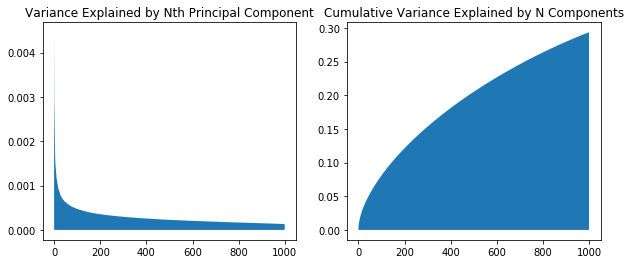

In [215]:
show_variance_explained_plots(pca_tfidf)

In [216]:
print_topics(pca_tfidf, tfidf, top_n=20)

Topic 0:
[('friend', '0.1702'), ('peopl', '0.1482'), ('music', '0.1467'), ('work', '0.1444'), ('movi', '0.1238'), ('new', '0.1237'), ('food', '0.1237'), ('book', '0.1059'), ('tri', '0.1047'), ('live', '0.0982'), ('read', '0.0965'), ('look', '0.0964'), ('famili', '0.0944'), ('fun', '0.0873'), ('year', '0.0862'), ('travel', '0.0836'), ('play', '0.0830'), ('person', '0.0816'), ('watch', '0.0788'), ('someon', '0.0784')]
Topic 1:
[('friend', '0.2755'), ('famili', '0.2107'), ('new', '0.1725'), ('famili friend', '0.1427'), ('travel', '0.1394'), ('fun', '0.1375'), ('meet', '0.1110'), ('work', '0.1042'), ('smile', '0.0983'), ('friend famili', '0.0920'), ('tri new', '0.0900'), ('write', '-0.0897'), ('sport', '0.0870'), ('meet new', '0.0839'), ('someon', '0.0823'), ('laugh', '0.0788'), ('new peopl', '0.0752'), ('art', '-0.0749'), ('hang', '0.0727'), ('http', '-0.0720')]
Topic 2:
[('movi', '-0.1528'), ('someon', '0.1471'), ('game', '-0.1423'), ('relationship', '0.1367'), ('show', '-0.1259'), ('loo

In [217]:
X_tfidf.shape

(59946, 1000)

In [219]:
min_ratio = 1
best_i = np.inf
for i in np.linspace(.75,.9, 10):
    clustering = DBSCAN(eps=i, metric='cosine', n_jobs=-1).fit(X_tfidf[:2000])
    ratio = (clustering.labels_==-1).sum()/len(clustering.labels_)
    print(i, ratio, len(np.unique(clustering.labels_)))
    if ratio < min_ratio:
        min_ratio = ratio
        best_i = i
        
print(min_ratio, best_i)

0.75 0.214 4
0.7666666666666667 0.1135 2
0.7833333333333333 0.0565 2
0.8 0.035 3
0.8166666666666667 0.0285 4
0.8333333333333334 0.028 4
0.85 0.022 4
0.8666666666666667 0.0205 3
0.8833333333333333 0.018 2
0.9 0.0145 2
0.0145 0.9


In [234]:
clustering = DBSCAN(eps=.879, metric='cosine', n_jobs=-1).fit(X_tfidf[:2000])

Counter(clustering.labels_)

Counter({0: 1941, -1: 36, 1: 23})

## NMF
### countvec

In [118]:
with open('words_sparse_matrix.pkl', 'rb') as handle:
    X_cv = pickle.load(handle)

with open('countvec.pkl', 'rb') as handle:
    cv = pickle.load(handle)

In [34]:
nmf = NMF(n_components=10)
X_cv = nmf.fit_transform(X_cv)

In [35]:
nmf.components_

array([[0.00567688, 0.00296725, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00038794, ..., 0.        , 0.00056306,
        0.        ],
       [0.        , 0.        , 0.02530304, ..., 0.01090591, 0.00215014,
        0.00216686],
       ...,
       [0.        , 0.        , 0.00055915, ..., 0.00211064, 0.        ,
        0.        ],
       [0.01415086, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00222703, ..., 0.        , 0.        ,
        0.        ]])

In [36]:
top_20_topic_words = list(map(lambda lst: lst.argsort()[-20:][::-1], nmf.components_))

In [37]:
top_20_topic_words[0].shape

(20,)

In [38]:
for i in range(len(top_20_topic_words)):
    print(np.array(cv.get_feature_names())[top_20_topic_words[i]])

['friend' 'famili' 'movi' 'fun' 'laugh' 'famili friend' 'look'
 'friend famili' 'someon' 'food' 'person' 'smile' 'great' 'hang' 'home'
 'travel' 'dinner' 'watch' 'guy' 'happi']
['word' 'word word' 'five' 'hundr' 'thou' 'profil' 'word profil' 'complet'
 'random' 'profil complet' 'complet random' 'f' 'p' 'k' 'h' 'l' 'e' 'r'
 'g' 'n']
['look' 'someon' 'way' 'feel' 'well' 'find' 'person' 'world' 'live' 'say'
 'take' 'interest' 'see' 'relationship' 'woman' 'read' 'open' 'need'
 'year' 'day']
['music' 'food' 'danc' 'play' 'live' 'art' 'listen' 'show' 'rock' 'book'
 'band' 'classic' 'film' 'guitar' 'world' 'cook' 'creativ' 'jazz' 'movi'
 'sing']
['http' 'com' 'watch' 'www' 'http www' 'v' 'youtub' 'youtub com'
 'www youtub' 'com watch' 'watch v' 'featur' 'u' 'world' 'child' 'relat'
 'cultur' 'energi' 'list' 'heart']
['peopl' 'meet' 'person' 'friend' 'laugh' 'talk' 'new' 'tri' 'say' 'feel'
 'interest' 'way' 'alway' 'around' 'pretti' 'help' 'tell' 'kind' 'notic'
 'fun']
['movi' 'book' 'food' 're

### tfidf

In [236]:
with open('matrix_tfidf.pkl', 'rb') as handle:
    X_tfidf = pickle.load(handle)
    
with open('tfidfvec.pkl', 'rb') as handle:
    tfidf = pickle.load(handle)

In [200]:
# nmf_tfidf = NMF(n_components=30)
# X_tfidf = nmf_tfidf.fit_transform(X_tfidf)

In [201]:
# with open('nmf_model_tfidf.pkl', 'wb') as f:
#     pickle.dump(nmf_tfidf, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('nmf_mtx_tfidf.pkl', 'wb') as f:
#     pickle.dump(X_tfidf, f, protocol=pickle.HIGHEST_PROTOCOL)

In [237]:
with open('nmf_model_tfidf.pkl', 'rb') as f:
    nmf_tfidf = pickle.load(f)
with open('nmf_mtx_tfidf.pkl', 'rb') as f:
    X_tfidf = pickle.load(f)

In [238]:
X_tfidf.shape

(59946, 30)

In [204]:
print_topics(nmf_tfidf, tfidf, n_topics=30, top_n=20)

Topic 0:
[('pretti', '0.6640'), ('profil', '0.6638'), ('mean', '0.6348'), ('year', '0.6226'), ('stuff', '0.6206'), ('write', '0.6006'), ('take', '0.5732'), ('ever', '0.5507'), ('read', '0.5452'), ('messag', '0.5389'), ('back', '0.5261'), ('oh', '0.5149'), ('tri', '0.5089'), ('see', '0.5088'), ('first', '0.4948'), ('serious', '0.4935'), ('let', '0.4880'), ('word', '0.4826'), ('might', '0.4807'), ('mayb', '0.4769')]
Topic 1:
[('tri', '1.9181'), ('new', '1.7084'), ('tri new', '1.1099'), ('alway', '0.5386'), ('restaur', '0.4890'), ('new restaur', '0.4249'), ('learn', '0.3865'), ('explor', '0.3521'), ('place', '0.3368'), ('new place', '0.3215'), ('learn new', '0.2507'), ('open', '0.2390'), ('citi', '0.2291'), ('alway tri', '0.2213'), ('new food', '0.2128'), ('explor new', '0.2114'), ('experi', '0.1972'), ('pretti', '0.1788'), ('figur', '0.1705'), ('adventur', '0.1686')]
Topic 2:
[('open', '0.5566'), ('relationship', '0.5341'), ('connect', '0.4958'), ('natur', '0.4888'), ('woman', '0.4610'),

[('work', '3.8188'), ('hard', '1.1082'), ('work hard', '0.6969'), ('work work', '0.3953'), ('busi', '0.3679'), ('job', '0.3625'), ('hard play', '0.3101'), ('week', '0.2919'), ('hard work', '0.2891'), ('play hard', '0.2825'), ('current work', '0.2794'), ('compani', '0.2734'), ('school', '0.2583'), ('current', '0.2535'), ('gym', '0.2222'), ('full', '0.2200'), ('car', '0.1979'), ('work full', '0.1869'), ('goal', '0.1812'), ('weekend', '0.1737')]
Topic 20:
[('laugh', '2.8039'), ('smile', '1.5830'), ('peopl laugh', '0.7932'), ('dog', '0.5320'), ('funni', '0.4047'), ('eye', '0.3752'), ('laughter', '0.3699'), ('smile laugh', '0.3553'), ('happi', '0.2996'), ('laugh smile', '0.2908'), ('joke', '0.2867'), ('laugh laugh', '0.2462'), ('girl', '0.2293'), ('take', '0.2280'), ('live', '0.2162'), ('eye smile', '0.2135'), ('serious', '0.1928'), ('alway', '0.1908'), ('laugh peopl', '0.1758'), ('heart', '0.1737')]
Topic 21:
[('peopl', '3.6154'), ('person', '0.8238'), ('talk', '0.7077'), ('help', '0.5166'

In [239]:
min_ratio = 1
best_i = np.inf
for i in np.linspace(.22,.29, 10):
    clustering = DBSCAN(eps=i, metric='cosine', n_jobs=-1).fit(X_tfidf[:5000])
    ratio = (clustering.labels_==-1).sum()/len(clustering.labels_)
    print(i, ratio, len(np.unique(clustering.labels_)))
    if ratio < min_ratio:
        min_ratio = ratio
        best_i = i
        
print(min_ratio, best_i)

0.22 0.0806 2
0.22777777777777777 0.0622 2
0.23555555555555555 0.0512 2
0.24333333333333332 0.044 3
0.2511111111111111 0.0406 2
0.2588888888888889 0.0384 2
0.26666666666666666 0.0378 2
0.27444444444444444 0.0366 2
0.2822222222222222 0.0366 2
0.29 0.036 2
0.036 0.29


In [210]:
clustering = DBSCAN(eps=.24, metric='cosine', n_jobs=-1).fit(X_tfidf[:5000])
clustering.labels_

Counter(clustering.labels_)

Counter({0: 4762, -1: 235, 1: 3})

## SKLEARN LDA
### tfidf

In [240]:
with open('matrix_tfidf.pkl', 'rb') as handle:
    X_tfidf = pickle.load(handle)
    
with open('tfidfvec.pkl', 'rb') as handle:
    tfidf = pickle.load(handle)

In [241]:
# lda_model = LatentDirichletAllocation(n_components=30, learning_method='online')
# lda_Z = lda_model.fit_transform(X_tfidf)
# print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

(59946, 30)


In [242]:
# with open('lda_model_tfidf.pkl', 'wb') as f:
#     pickle.dump(lda_model, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('lda_mtx_tfidf.pkl', 'wb') as f:
#     pickle.dump(lda_Z, f, protocol=pickle.HIGHEST_PROTOCOL)

In [243]:
with open('lda_model_tfidf.pkl', 'rb') as handle:
    lda_model = pickle.load(handle)
    
with open('lda_mtx_tfidf.pkl', 'rb') as handle:
    lda_Z = pickle.load(handle)

In [244]:
print_topics(lda_model, tfidf)

Topic 0:
[('work youth', '7.2636'), ('goal futur', '5.9478'), ('career next', '5.3201'), ('profan', '5.2828'), ('pretti full', '4.6433'), ('roommat watch', '4.0572'), ('son brother', '4.0128'), ('social creatur', '3.4467'), ('nobodi perfect', '3.1190'), ('joseph conrad', '0.0333')]
Topic 1:
[('kyli', '9.1547'), ('dalai', '7.3906'), ('minogu', '7.2465'), ('kyli minogu', '7.1564'), ('dalai lama', '7.0680'), ('haha music', '5.5546'), ('mishima', '5.2175'), ('kat', '5.1119'), ('coffe water', '4.7609'), ('intang', '4.7480')]
Topic 2:
[('bebop', '17.7914'), ('cowboy bebop', '15.4334'), ('bloodi valentin', '13.5467'), ('rilo kiley', '12.7667'), ('cocteau', '12.7274'), ('cocteau twin', '12.1884'), ('amon', '11.9547'), ('stereolab', '11.8865'), ('lili allen', '11.8503'), ('sleater', '11.5345')]
Topic 3:
[('person hang', '12.7733'), ('conrad', '6.0522'), ('believ happi', '4.6111'), ('home happi', '4.5914'), ('fbi', '3.7922'), ('friend various', '3.6843'), ('car driver', '3.6382'), ('date experi'

In [251]:
min_ratio = 1
best_i = np.inf
for i in np.linspace(.2,.8, 10):
    clustering = DBSCAN(eps=i, metric='cosine', n_jobs=-1).fit(lda_Z[:5000])
    ratio = (clustering.labels_==-1).sum()/len(clustering.labels_)
    print(i, ratio, len(np.unique(clustering.labels_)))
    if ratio < min_ratio:
        min_ratio = ratio
        best_i = i
        
print(min_ratio, best_i)

0.2 0.0006 3
0.2666666666666667 0.0006 3
0.33333333333333337 0.0004 3
0.4 0.0004 3
0.46666666666666673 0.0004 3
0.5333333333333334 0.0002 3
0.6000000000000001 0.0002 2
0.6666666666666667 0.0002 2
0.7333333333333334 0.0 1
0.8 0.0 1
0.0 0.7333333333333334


In [257]:
clustering = DBSCAN(eps=.5, metric='cosine', n_jobs=-1).fit(lda_Z[:5000])
clustering.labels_

Counter(clustering.labels_)

Counter({0: 4821, 1: 178, -1: 1})

## GENSIM LSA
### countvec

In [ ]:
with open('words_sparse_matrix.pkl', 'rb') as handle:
    X_cv = pickle.load(handle)

with open('countvec.pkl', 'rb') as handle:
    cv = pickle.load(handle)

### tfidf

In [17]:
with open('matrix_tfidf.pkl', 'rb') as handle:
    X_tfidf = pickle.load(handle)
    
with open('tfidfvec.pkl', 'rb') as handle:
    tfidf = pickle.load(handle)

In [18]:
tfidf_corpus = matutils.Sparse2Corpus(X_tfidf.transpose())
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

In [19]:
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=50)

In [20]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]
doc_vecs[0]

[(0, 0.19463955910776978),
 (1, -0.04178422012008727),
 (2, 0.009832276970300797),
 (3, 0.07111000463872623),
 (4, -0.03215092114661114),
 (5, -0.022463073765220144),
 (6, -0.017575044945317645),
 (7, -0.029848820534485208),
 (8, -0.024341856960793974),
 (9, 0.047523085566066756),
 (10, 0.04615278985672612),
 (11, 0.0025005978744359),
 (12, -0.029231959222306717),
 (13, -0.01321648729998309),
 (14, 0.016087965924369865),
 (15, 0.0005131853741780074),
 (16, -0.009774869163373164),
 (17, 0.023528144295638882),
 (18, 0.04824154728581441),
 (19, 0.010640236293827791),
 (20, -0.0014127900633206223),
 (21, 0.016267082295049477),
 (22, -0.008312180212859753),
 (23, 0.009312971014517826),
 (24, -0.019201063428775235),
 (25, -0.011924215612989043),
 (26, -0.05235817391841218),
 (27, 0.040911227124708),
 (28, -0.015391015602109901),
 (29, -0.017071594695797575),
 (30, -0.0032924086232902073),
 (31, -0.007568359011439058),
 (32, 0.017571950648526603),
 (33, -0.003126415285631875),
 (34, -0.016890

In [21]:
# Create an index transformer that calculates similarity based on 
# our space
index = similarities.MatrixSimilarity(doc_vecs, num_features=50)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [22]:
# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[0]]), key=lambda item: -item[1])
sims

[(0, 1.0),
 (1781, 0.84022695),
 (25793, 0.8392988),
 (44243, 0.8364821),
 (10282, 0.8352558),
 (43566, 0.8337328),
 (3117, 0.83302706),
 (22867, 0.8308245),
 (28454, 0.82978576),
 (20649, 0.82894665),
 (29523, 0.8266766),
 (13617, 0.81947935),
 (15125, 0.8170841),
 (28496, 0.81686217),
 (23476, 0.8158159),
 (47904, 0.8137245),
 (22214, 0.81301135),
 (24885, 0.8117191),
 (5404, 0.8103597),
 (36566, 0.8089445),
 (24853, 0.8085469),
 (4016, 0.80844396),
 (56084, 0.80725425),
 (29733, 0.80681056),
 (9730, 0.8063597),
 (6407, 0.80581033),
 (59220, 0.8040046),
 (47619, 0.80384886),
 (24282, 0.80339366),
 (55713, 0.8024248),
 (56465, 0.80059165),
 (18275, 0.80035776),
 (39045, 0.8001164),
 (10822, 0.7990748),
 (30695, 0.79870224),
 (30516, 0.7983798),
 (8152, 0.79776174),
 (59781, 0.79629934),
 (52969, 0.7955997),
 (45845, 0.79550177),
 (44760, 0.79541117),
 (12324, 0.79536384),
 (36625, 0.7949656),
 (27919, 0.7945366),
 (30394, 0.79433715),
 (30831, 0.79433715),
 (35902, 0.7935362),
 (27360

In [23]:
# Let's take a look at how we did
for sim_doc_id, sim_score in sims[0:3]: 
    print("Score: " + str(sim_score))
    print("Document: " + X[0][sim_doc_id])

Score: 1.0
Document: about me:<br />
<br />
i would love to think that i was some some kind of intellectual:
either the dumbest smart guy, or the smartest dumb guy. can't say i
can tell the difference. i love to talk about ideas and concepts. i
forge odd metaphors instead of reciting cliches. like the
simularities between a friend of mine's house and an underwater
salt mine. my favorite word is salt by the way (weird choice i
know). to me most things in life are better as metaphors. i seek to
make myself a little better everyday, in some productively lazy
way. got tired of tying my shoes. considered hiring a five year
old, but would probably have to tie both of our shoes... decided to
only wear leather shoes dress shoes.<br />
<br />
about you:<br />
<br />
you love to have really serious, really deep conversations about
really silly stuff. you have to be willing to snap me out of a
light hearted rant with a kiss. you don't have to be funny, but you
have to be able to make me laugh. yo

In [25]:
lsi.print_topics()

[(0,
  '0.163*"friend" + 0.142*"peopl" + 0.142*"time" + 0.141*"music" + 0.139*"work" + 0.119*"movi" + 0.119*"food" + 0.119*"new" + 0.102*"book" + 0.101*"tri"'),
 (1,
  '0.281*"friend" + 0.215*"famili" + 0.175*"new" + 0.145*"famili friend" + 0.144*"travel" + 0.133*"fun" + 0.108*"work" + 0.105*"meet" + 0.095*"smile" + 0.094*"friend famili"'),
 (2,
  '-0.152*"someon" + 0.150*"movi" + 0.137*"game" + 0.131*"show" + -0.130*"relationship" + 0.127*"music" + -0.125*"look" + 0.113*"food" + -0.111*"woman" + -0.106*"person"'),
 (3,
  '0.202*"lol" + -0.169*"travel" + 0.141*"guy" + 0.127*"game" + -0.120*"live" + -0.112*"explor" + 0.109*"na" + -0.108*"citi" + -0.108*"new" + -0.107*"san"'),
 (4,
  '0.270*"music" + 0.186*"danc" + -0.151*"san" + 0.146*"food" + -0.140*"san francisco" + -0.140*"francisco" + 0.140*"art" + 0.138*"movi" + -0.136*"new" + -0.129*"year"'),
 (5,
  '0.346*"http" + 0.332*"com" + 0.320*"www" + 0.316*"http www" + 0.286*"youtub com" + 0.284*"www youtub" + 0.280*"youtub" + 0.276*"com 